In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [67]:
data = pd.read_csv("train.csv", dtype = {'VisitNumber': str, 'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

In [68]:
#Leave out Upc
data.drop('Upc', axis = 1, inplace = True)

## Step 0: Explorative Data Analysis

In [69]:
data.info() #647054 rows × 6 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 6 columns):
TripType                 647054 non-null category
VisitNumber              647054 non-null object
Weekday                  647054 non-null category
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 21.0+ MB


In [70]:
data.describe()

,ScanCount
count,647054.000000
mean,1.108878
std,0.700776
min,-12.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,71.000000


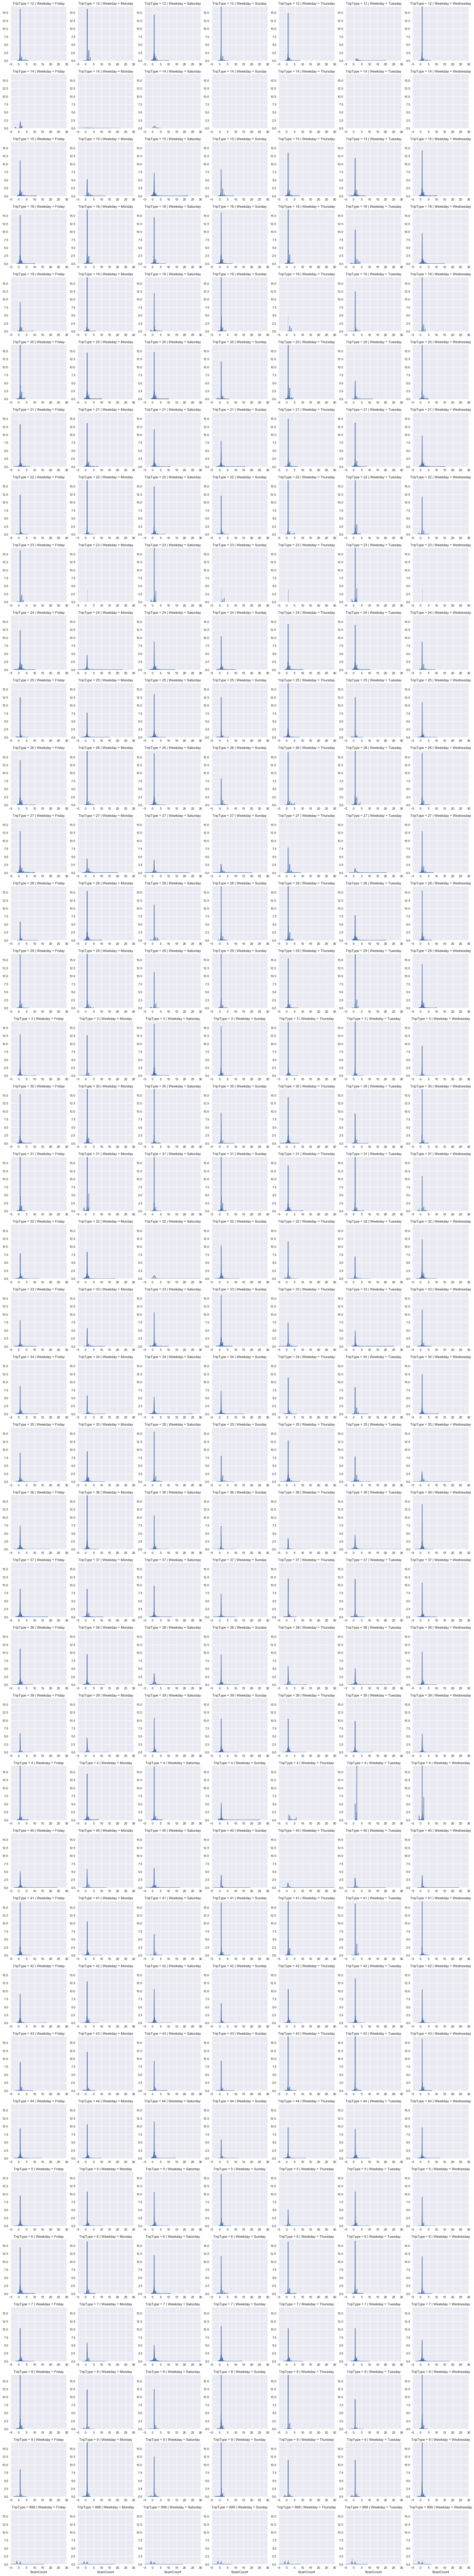

In [6]:
sns.set(style="darkgrid")
g = sns.FacetGrid(data, row='TripType', col='Weekday')
g.map(sns.distplot, "ScanCount")
plt.xticks(np.arange(-5, 40, step=5))
plt.xlim(-5, 30)
plt.show()

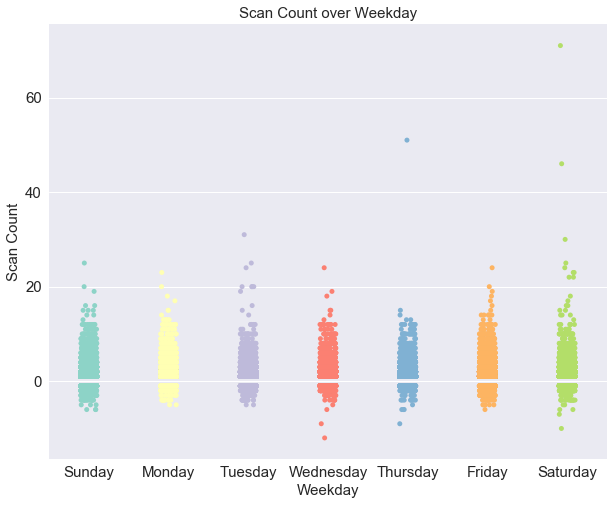

In [93]:
plt.figure(figsize = (10,8))
sns.set(style="darkgrid")
axis_font = {'size':'15'}
label = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.stripplot(x="Weekday", y="ScanCount", data=data, order = label, palette = "Set3", jitter=True) 
plt.title("Scan Count over Weekday",**axis_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.xlabel("Weekday",  **axis_font)
plt.ylabel("Scan Count",  **axis_font)
plt.show()

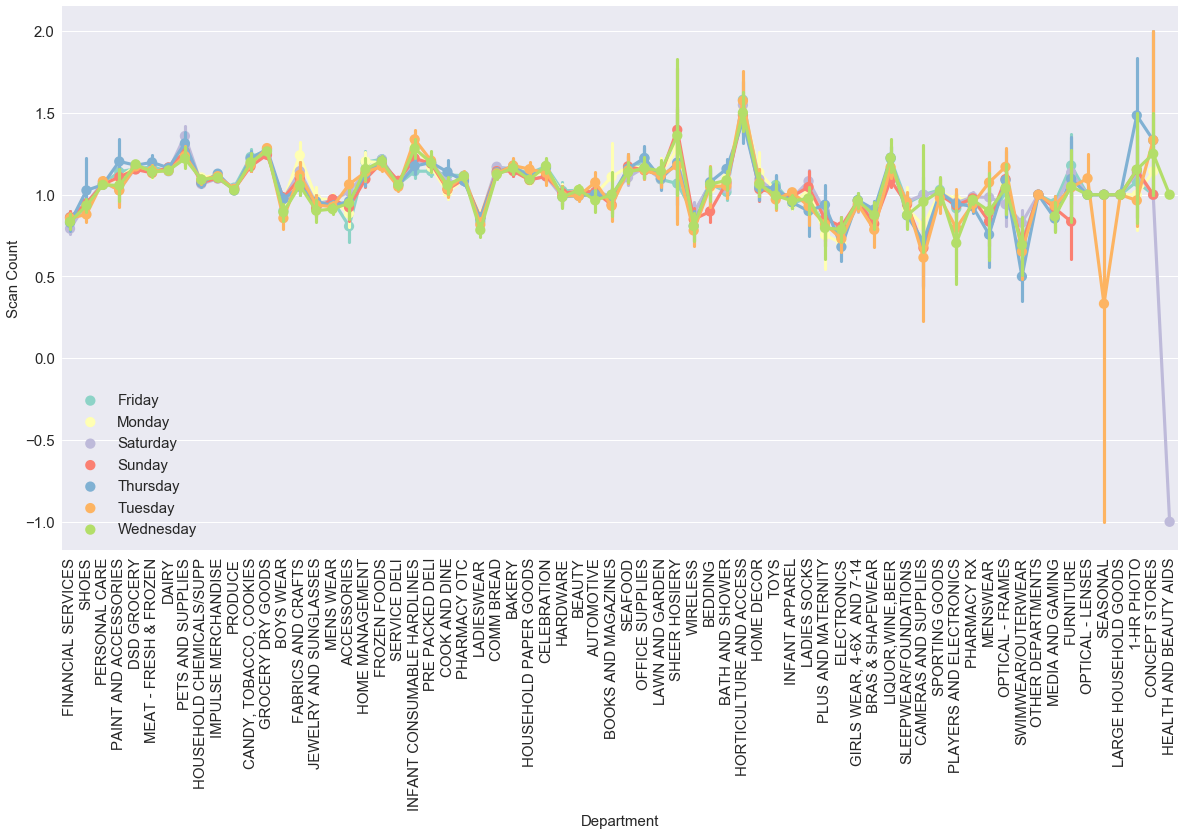

In [90]:
plt.figure(figsize = (20,10))
sns.pointplot(x="DepartmentDescription", y="ScanCount", hue="Weekday", data= data, palette= "Set3")
axis_font = {'size':'15'}
plt.xticks(rotation=90,  **axis_font)
plt.xlabel("Department",  **axis_font)
plt.ylabel("Scan Count",  **axis_font)
plt.yticks(**axis_font)
plt.legend(fontsize=15)
plt.show()

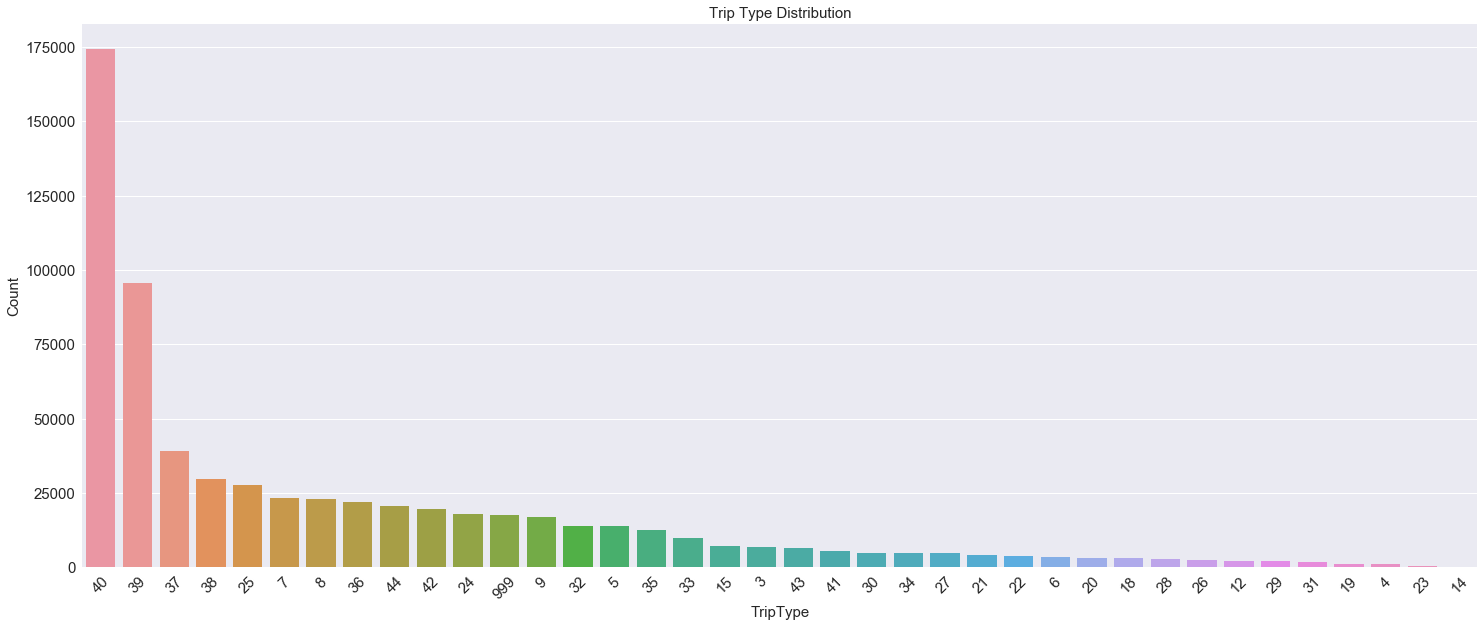

In [83]:
plt.figure(figsize = (25,10))
sns.countplot(x="TripType", data=data, order = data['TripType'].value_counts().index)
axis_font = {'size':'15'}
plt.title("Trip Type Distribution", **axis_font)
plt.xticks(rotation=45, **axis_font)
plt.yticks(**axis_font)
plt.xlabel("TripType",**axis_font)
plt.ylabel("Count",**axis_font)
plt.show()

## Step 1: Data Preprocess

### Missing Value

In [71]:
data.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

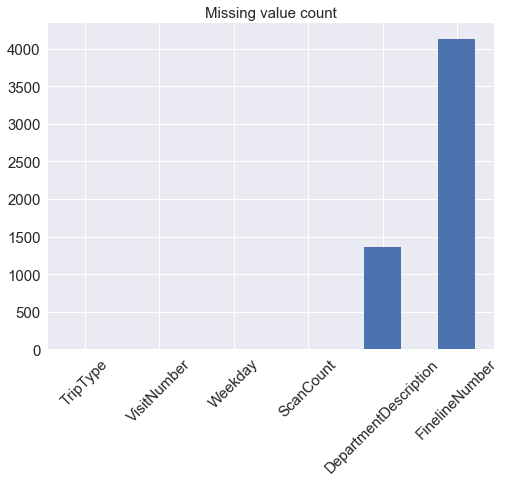

In [79]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
axis_font = {'size':'15'}
data.isnull().sum().plot.bar()
plt.title("Missing value count", **axis_font)
plt.xticks(rotation=45, **axis_font) 
plt.yticks(**axis_font) 
plt.show()

(array([  6.,   0.,   0.,   1.,   0.,   0.,  84.,   0.,   0.,  63.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

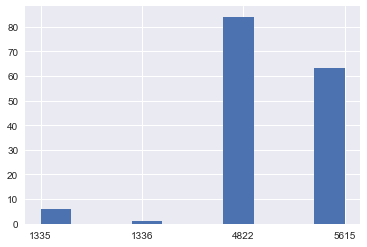

In [12]:
data[(data['DepartmentDescription'].isnull()) | (data['FinelineNumber'].isnull())] #4129 rows
pharmacy_null = data[((data['FinelineNumber'].isnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] #2768 rows
pharmacy_notnull = data[((data['FinelineNumber'].notnull())) & (data['DepartmentDescription'] == 'PHARMACY RX')] 
plt.hist(pharmacy_notnull['FinelineNumber'])

In [13]:
#Deal with missing FinelineNumber in 'PHARMACY RX' with replacement of '9999'
phar_missing_index = list(data[(data['DepartmentDescription'] == 'PHARMACY RX') & (data['FinelineNumber'].isnull())].index)
for i in phar_missing_index:
    data["FinelineNumber"].iloc[i] = "9999"

In [14]:
data.dropna(inplace = True) 

In [15]:
trip = list(data[['VisitNumber', 'TripType']].drop_duplicates()['TripType'])

In [16]:
data.drop('TripType', axis = 1, inplace = True)#(645693, 5)

### Spreading features

#### 1. FinelineNumber

In [17]:
data['VisitNumber'] = data['VisitNumber'].astype(int, copy=False)

In [18]:
len(data['VisitNumber'].unique())

95516

In [19]:
group_visit_fineline = data.groupby(['VisitNumber','FinelineNumber']).agg({'FinelineNumber':'count'})

In [20]:
fn = group_visit_fineline.unstack() 

In [21]:
fn = fn['FinelineNumber']
fn.fillna(0, inplace= True)

In [22]:
#finelineNumber columns
fn_seq = list(fn.columns)

In [23]:
X = np.array(fn) #(95516, 5196)

In [24]:
#X[X > 0] = 1

In [25]:
#visitNumber sequence
vn_seq = list(fn.index)

#### 2. Weekday

In [26]:
day = pd.get_dummies(data[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

In [27]:
day.drop('VisitNumber', axis = 1, inplace = True)

In [28]:
day.head()
day = day[['Weekday_Sunday', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday']]

In [29]:
day_seq= list(day.columns)

In [30]:
X_day = np.array(day)

In [31]:
temp = np.concatenate((X, X_day), axis=1)

In [32]:
temp.shape

(95516, 5203)

#### 3. DepartmentDescription

In [33]:
dept = data.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})
dept = dept.unstack()
dept = dept['DepartmentDescription']
dept.fillna(0, inplace= True)

In [34]:
dept_seq= list(dept.columns)

In [35]:
department = np.array(dept) 
#department[department > 0] = 1

In [36]:
final = np.concatenate((temp, department), axis=1) #(95516, 5271)

In [37]:
final = final.astype(np.float32, copy=False)#(95516, 5271)

#### 4. ScanCount

In [38]:
sc = data.groupby(['VisitNumber'], as_index = False).agg({'ScanCount':'sum'})

In [39]:
def scanlevel(row):
    if row <0 :
        return 'return'
    elif row<5:
        return "few"
    elif row <15:
        return "medium"
    else:
        return "many"

In [40]:
sc["sc_level"] = sc["ScanCount"].apply(scanlevel)

In [41]:
sc.head()

,VisitNumber,ScanCount,sc_level
0,5,-1,return
1,7,2,few
2,8,27,many
3,9,3,few
4,10,3,few


In [42]:
sc_dummy = pd.get_dummies(sc[["VisitNumber", "sc_level"]], columns = ["sc_level"])

In [43]:
sc_dummy = sc_dummy[["VisitNumber", 'sc_level_return','sc_level_few','sc_level_medium','sc_level_many']]

In [44]:
sc_dummy.drop("VisitNumber", axis =1, inplace = True)

In [45]:
sc_seq = list(sc_dummy.columns)

In [46]:
sc_array = np.array(sc_dummy)

In [47]:
df = np.concatenate((final, sc_array), axis=1) #(95516, 5275)

In [48]:
header = [] #5275
header.extend(fn_seq)
header.extend(day_seq)
header.extend(dept_seq)
header.extend(sc_seq)

In [50]:
t = np.array(trip)
t = t.astype('int')
tt =t[:,np.newaxis]

In [53]:
from sklearn.cross_validation import train_test_split

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
#Stratify sampling subset of instances due to computation power 
X_sample, _, y_sample, _ = train_test_split(df, tt, stratify= tt, test_size=0.6)

In [59]:
from scipy import sparse
Xs_all = sparse.csr_matrix(df)
Xs_subset = sparse.csr_matrix(X_sample)

In [61]:
sparse.save_npz('df_sparse_matrix.npz', Xs_subset)
sparse.save_npz('df_all_sparse_matrix.npz', Xs_all)

In [62]:
np.savetxt('header.csv',header,fmt='%s',delimiter=',')
np.savetxt("triptype.csv", y_sample, delimiter = ",")
np.savetxt("triptype_all.csv", tt, delimiter = ",")
#source:https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html